In [1]:
# Data Science
import numpy  as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Tricks
sns.set(style='ticks', context='talk', font_scale=1.15)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
import skimage.io

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

vip_class = ['person','skis','snowboard']

IMAGE_SHAPE = (467, 700, 3)

# Load Data

In [3]:
data_df = pd.read_pickle('bulk_data_df.pkl')

# Process

In [4]:
data_df['class'] = [ class_names[i] for i in data_df['class_ids'] ]
imgs_size = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

data_df['box_size'] = (0.+data_df['x2']-data_df['x1'])*(0.+data_df['y2']-data_df['y1'])
data_df['box_size'] = data_df['box_size']/imgs_size*100

# Save Clean Data

In [5]:
drop_idx = data_df.rename(columns={'class':'Class'}).query('Class=="person" & (box_size<1 | scores<=0.9)').index

clean_df = (
    data_df
    .reset_index().set_index('class')
    .loc[vip_class]
    .reset_index().set_index('index')
    .drop(drop_idx).query('scores>0.7')
)
clean_df.to_pickle('bulk_clean_df.pkl')

---

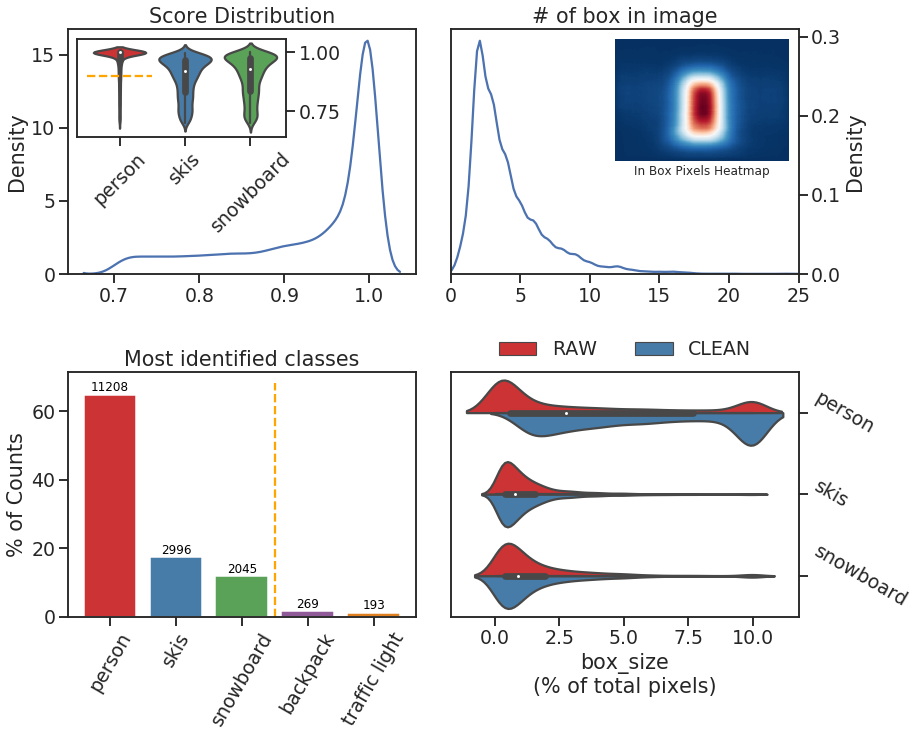

In [6]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(14,12))
################################################################################
# Fig1
################################################################################
# Score Distribution
sns.kdeplot(data_df['scores'],legend=None, ax=ax[0,0])
ax[0,0].set_title('Score Distribution')
ax[0,0].set_ylabel('Density')
################################################################################
# Score Violin
axins = inset_axes(ax[0,0], width='60%', height='40%', loc='upper left')
g = sns.violinplot(
    data=data_df.set_index('class').loc[vip_class,'scores'].reset_index(),
    x='class',
    y='scores',
    palette='Set1',
    scale='width',
    ax=axins
)
plt.setp(g.axes.get_xticklabels(), rotation=45)
for label in g.axes.get_yticklabels():
    label.set_horizontalalignment('center')

axins.yaxis.set_label_position("right")
axins.yaxis.set_ticks_position("right")  
axins.set_xlabel('')
axins.set_ylabel('')
axins.hlines(0.9, -0.5, 0.5, linestyles='dashed', color='orange')
################################################################################

################################################################################
# Fig2
################################################################################
# No. of Box per image
g = sns.kdeplot(data_df.groupby('imgID',sort=False).count()['class_ids'],legend=None, ax=ax[0,1])
ax[0,1].set_title('# of box in image')
ax[0,1].set_xlim(0,25)
ax[0,1].set_ylabel('Density')
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.set_ticks_position("right")  
################################################################################
# Box Heatmap
axins = inset_axes(ax[0,1], width='50%', height='50%', loc='upper right')

box_matrix = np.zeros((IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
for x1, y1, x2, y2 in clean_df[['x1','y1','x2','y2']].values:
    box_matrix[x1:x2, y1:y2] += 1

# mask_matrix = np.stack(
#     clean_df['masks'].apply(
#         lambda row: list(map(int, list(row)))
#     )
# ).reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1]).sum(axis=0)

g = sns.heatmap(box_matrix, cmap='RdBu_r',cbar=False, xticklabels=[],yticklabels=[],ax=axins)
g.set_xlabel('In Box Pixels Heatmap',fontsize=12)
################################################################################


################################################################################
# Fig3
################################################################################
# Classes counts

g = sns.barplot( 
    data=(
        ( data_df['class'].value_counts()/data_df.shape[0]*100 )
        .reset_index()
        .rename(columns={'index':'Class', 'class':'% of Counts'})[:5]
    ),
    x='Class',
    y='% of Counts',
    palette='Set1',
    ax=ax[1,0]
)
counts = data_df['class'].value_counts()[:5]
for i,p in enumerate(g.patches):
    ax[1,0].text(
        p.get_x()+p.get_width()/2, 
        p.get_height()+1, 
        counts[i], 
        fontsize=12, color='black', ha='center'
    )

plt.setp(g.axes.get_xticklabels(), rotation=60)
for label in g.axes.get_xticklabels():
    label.set_horizontalalignment('center')

ax[1,0].set_title('Most identified classes')
ax[1,0].set_xlabel('')
ax_ylim = ax[1,0].axes.get_ylim()
ax[1,0].vlines(2.5, ax_ylim[0], ax_ylim[1], linestyles='dashed', color='orange')
################################################################################

################################################################################
# Fig4
################################################################################
# Box Size Distribution
tmp_df = data_df.copy()
tmp_df['FLAG'] = 'RAW'
tmp_df = tmp_df.append(clean_df.assign(FLAG="CLEAN"), ignore_index=True, sort=False)
tmp_df['box_size'] = tmp_df['box_size'].clip(upper=10)

g = sns.violinplot( 
    data=tmp_df.set_index('class').loc[vip_class].reset_index(),
    x='box_size',
    y='class',
    orient='h',
    hue='FLAG',
    split=True,
    palette='Set1',
    hue_order=['RAW','CLEAN'],
    scale='width',
    ax=ax[1,1]
)
g.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2), frameon=False)

ax[1,1].set_xlabel('box_size\n(% of total pixels)')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.set_ticks_position("right")  
ax[1,1].set_ylabel('')

plt.setp(g.axes.get_yticklabels(), rotation=-30)
for label in g.axes.get_yticklabels():
    label.set_verticalalignment('center')
################################################################################
plt.subplots_adjust(hspace=0.4, wspace=0.1, bottom=0.2, right=0.85)
plt.show()

fig.savefig('DA.png')

---